In [395]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from itertools import combinations
from itertools import permutations

import random

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


In [396]:
word_data = pd.read_csv('../data/unigram_freq.csv')
word_data_top1000 = word_data.head(1000)

wheel_data = pd.read_csv('../data/wheeldata.csv')
wheel_data_nodup = wheel_data.drop_duplicates(subset=['Puzzle'])


As opposed to the previous code, where we tested the frequencies of letters across the whole dataset, we will now try to find a relationship between two variables using various approaches.

# Linear Regression

The metric we are using is how many letters of the puzzle for each guess will be solved out of the total letters in the puzzle. This is what we will use for both regression methods.

In [407]:
# regression set up

wheel_data_nodup['Puzzle'] = wheel_data_nodup.Puzzle.astype('str')

excluded = {'R', 'S', 'T', 'L', 'N', 'E', ' '}
letters = [chr(i) for i in range(65, 91) if chr(i) not in excluded]

vowels = {'A', 'E', 'I', 'O', 'U'}
consonants = set(letters) - vowels


def get_feature_vector(puzzle, guess_set):
    puzzle = puzzle.upper()
    letter_counts = [puzzle.count(l) for l in letters]
    guess_vector = [1 if l in guess_set else 0 for l in letters]
    return letter_counts + guess_vector

def get_reveal_score(puzzle, guess_set): # we make a guess with a combo of letters 
    return sum(1 for c in puzzle.upper() if c in guess_set and c not in excluded)/len(puzzle)

X_combinations = []
y_regress = []

guess_list = [] # this list stores all the guesses we used

for idx, row in wheel_data_nodup.iterrows():
    puzzle = row['Puzzle']
    puzzle_letters = set(puzzle.upper()) - excluded

    guesses = []
    for i in range(1000):
        cons = random.sample(list(consonants), 3)
        vwls = random.sample(list(vowels), 1)
        guesses.append(cons+vwls)

    for guess in guesses:
        guess_set = set(guess)
        features = get_feature_vector(puzzle, guess_set)
        score = get_reveal_score(puzzle, guess_set)
        
        X_combinations.append(features)
        y_regress.append(score)
        guess_list.append(''.join(guess))


C:\Users\axylo\AppData\Local\Temp\ipykernel_31484\3669270212.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wheel_data_nodup['Puzzle'] = wheel_data_nodup.Puzzle.astype('str')


In [409]:
# linear regression model set up and training
# x_arr and y_arr reused for logistic code
X_arr = np.array(X_combinations)
y_arr = np.array(y_regress)

X_train, X_test, y_train, y_test = train_test_split(X_arr, y_arr, test_size=0.2, random_state=42)

lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

y_pred = lin_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print(X_arr[0])
print(y_arr)

print(y_pred)

print(f"Linear Regression MSE: {mse:.2f}")

[0 0 0 1 0 0 2 1 0 0 0 1 1 0 2 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
[0.05882353 0.11764706 0.17647059 ... 0.21052632 0.10526316 0.10526316]
[0.12161349 0.12130439 0.07960296 ... 0.12751893 0.14600324 0.13313601]
Linear Regression MSE: 0.01


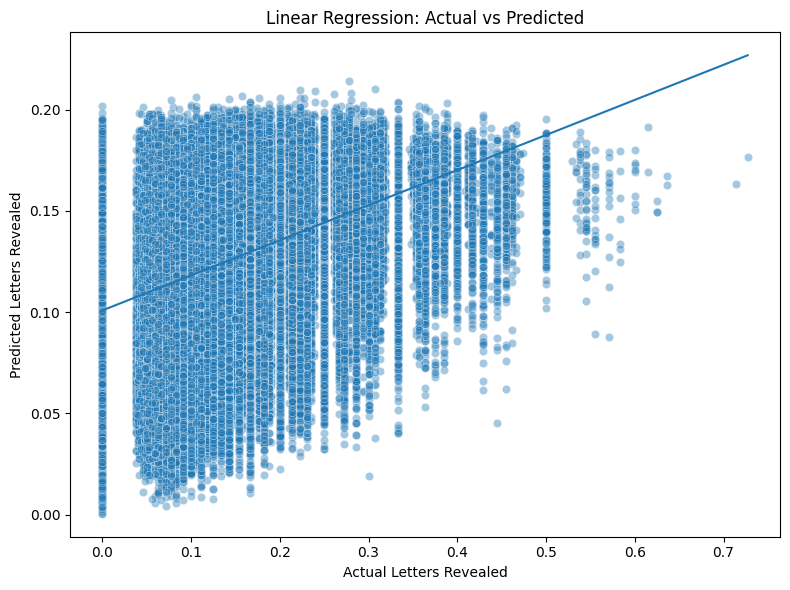

In [410]:
# plot actual vs predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.4)
plt.xlabel("Actual Letters Revealed")
plt.ylabel("Predicted Letters Revealed")
plt.title("Linear Regression: Actual vs Predicted")
m, b = np.polyfit(y_test, y_pred, 1)
xlinsp = np.linspace(min(y_test), max(y_test), 100)
plt.plot(xlinsp, m*xlinsp + b) 
plt.tight_layout()
plt.show()

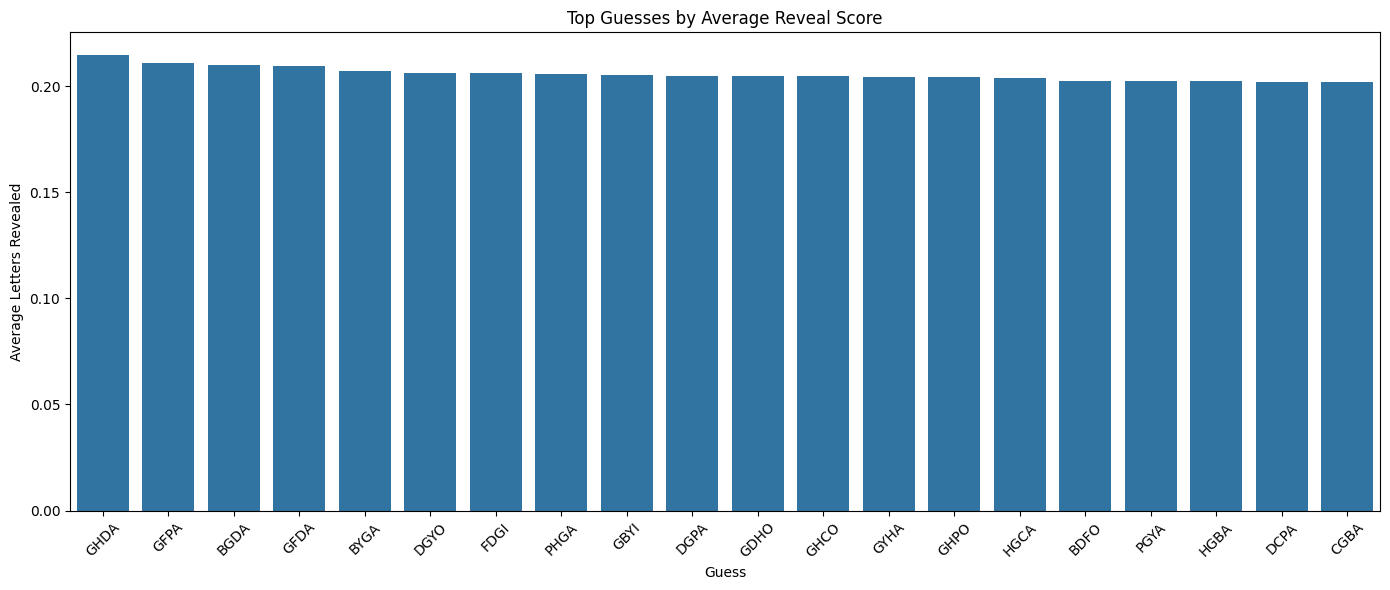

In [411]:

# df of results
performance_df = pd.DataFrame({
    'Guess': guess_list,
    'RevealScore': y_regress
})

# groups by guess and compute average score
avg_score_df = performance_df.groupby('Guess')['RevealScore'].mean().reset_index()
avg_score_df = avg_score_df.sort_values('RevealScore', ascending=False)

# plots top 20 guesses
plt.figure(figsize=(14, 6))
sns.barplot(data=avg_score_df.head(20), x='Guess', y='RevealScore')
plt.title('Top Guesses by Average Reveal Score')
plt.ylabel('Average Letters Revealed')
plt.xlabel('Guess')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Logistic Regression Model:

In [ ]:
# classification target
y_class = [1 if score >= 0.48 else 0 for score in y_regress] 

X_train, X_test, y_train, y_test = train_test_split(X_combinations, y_class, test_size=0.2, random_state=42)

# fit to model
log_model = LogisticRegression(max_iter=10000)
log_model.fit(X_train, y_train)

# predict probabilities and classes
y_pred_proba = log_model.predict_proba(X_test)[:, 1]
y_pred_log = log_model.predict(X_test)
acc = accuracy_score(y_test, y_pred_log)


print("Accuracy Score: ", acc)



Accuracy Score:  0.9991340782122905


If over 48% of the individual puzzle is solved, then we shall classify it as a "good" guess. Otherwise, the guess is "bad" and will not work as well.

We shared the data with the previous regression model and made a classification for our logistic model. The accuracy score here is greater than 0.999, which is a good sign.

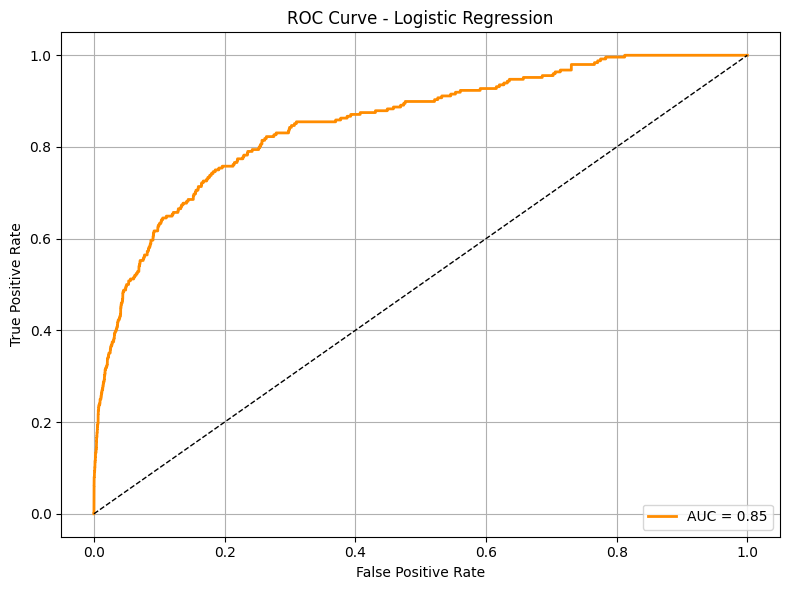

<Figure size 600x600 with 0 Axes>

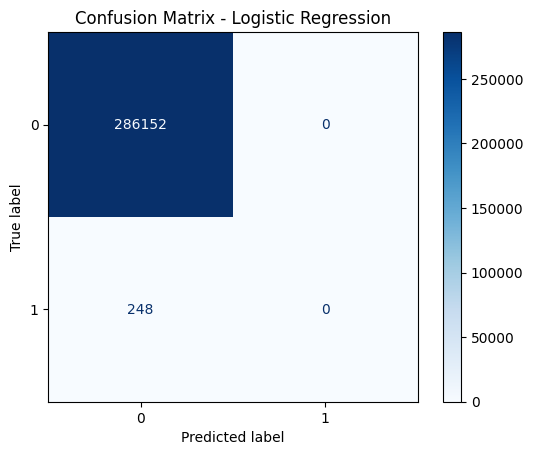

In [406]:
# Compute ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], 'k--', lw=1)  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_model.classes_)
plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Logistic Regression")
plt.grid(False)
plt.show()
